# Анализ AB-теста. Новая система рекомендаций

## 1. Обзор и предобработка

**Импорты**

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
from datetime import timedelta 
from plotly import graph_objects as go
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

import warnings
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default = "png"

**Апдейты**

In [2]:
#!pip install plotly --upgrade --user
#!pip install -U seaborn

**Данные**

In [3]:
df_marketing_events = pd.read_csv('ab_project_marketing_events.csv')
df_all_new_users = pd.read_csv('final_ab_new_users.csv')
df_user_events = pd.read_csv('final_ab_events.csv')
df_test_participants = pd.read_csv('final_ab_participants.csv')

**Таблица маркетинговых мероприятий**

In [4]:
df_marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [5]:
df_marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


Что сделать:
- Даты в datetime
- Дубликаты

In [6]:
df_marketing_events['start_dt'] = pd.to_datetime(df_marketing_events['start_dt'], format='%Y-%m-%d')
df_marketing_events['finish_dt'] = pd.to_datetime(df_marketing_events['start_dt'], format='%Y-%m-%d')

In [7]:
print('Дубликатов в таблице:', df_marketing_events.duplicated().sum())

Дубликатов в таблице: 0


**Таблица новых пользователей**

Зарегистрировавшиеся с 7 по 21 декабря 2020 года

In [8]:
df_all_new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [9]:
df_all_new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


Что сделать:
- Дату в datetime
- Дубликаты
- Значения категориальных столбцов
- Диапозон дат

In [10]:
df_all_new_users['first_date'] = pd.to_datetime(df_all_new_users['first_date'], format='%Y-%m-%d')

In [11]:
print('Дубликатов в таблице:', df_all_new_users.duplicated().sum())

Дубликатов в таблице: 0


Один и тот же пользователь случайно не попал в регистрацию два раза: в разные даты и с разных устройств? Посмотрим дубликаты только по user_id.

In [12]:
print('Дубликатов user_id в таблице:', df_all_new_users.duplicated(subset='user_id').sum())

Дубликатов user_id в таблице: 0


In [13]:
df_all_new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [14]:
df_all_new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

В категориальных значениях все ок: повторений с разными написаниями нет. 

In [15]:
df_all_new_users['first_date'].describe(datetime_is_numeric=True)

count                            61733
mean     2020-12-14 23:38:12.796397568
min                2020-12-07 00:00:00
25%                2020-12-11 00:00:00
50%                2020-12-15 00:00:00
75%                2020-12-20 00:00:00
max                2020-12-23 00:00:00
Name: first_date, dtype: object

А вот последняя дата регистрации не совпадает с границей диапозона. Должны были закончить набирать пользователей 21 декабря, а последние регистрации есть 23 декабря. Стоит проверить - попали ли нужные нам пользователи в описанный интервал. Возможно, в наших тестовых группах нет пользователей, зарегестрированных 22 или 23 декабря и тогда - все ок. 

**Таблица действий новых пользователей**

В период с 7 декабря 2020 по 4 января 2021 года.

In [16]:
df_user_events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [17]:
df_user_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


Есть куча пропусков в столбце с деталями, но это не страшно. В описании к данным сказано, что там хранится дополнительное инфо (стоимость покупки) о событии purchase. Совсем необязательно, чтобы детали были к каждому событию. Интересно посмотреть - ко всем ли событям 'purchase' указана сумма покупки. 

Что сделать:
- Дату в datetime
- Дубликаты
- Значения в категориальном столбце event_name
- Диапозон дат
- Пропуски в столбце details (по фильтру event_name == purchase)

In [18]:
df_user_events['event_dt'] = pd.to_datetime(df_user_events['event_dt'], format='%Y-%m-%d %H:%M:%S')

In [19]:
print('Дубликатов в таблице:', df_user_events.duplicated().sum())

Дубликатов в таблице: 0


In [20]:
df_user_events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Лишних значений нет. Сразу видим всю воронку. 

In [21]:
df_user_events['event_dt'].describe(datetime_is_numeric=True)

count                           440317
mean     2020-12-18 16:33:30.344980992
min                2020-12-07 00:00:33
25%                2020-12-14 06:38:31
50%                2020-12-19 02:14:36
75%                2020-12-22 23:47:03
max                2020-12-30 23:36:33
Name: event_dt, dtype: object

Данные о действиях пользователей попадают в необходимый диапозон (7 декабря - 4 января), но заканчиваются даже раньше. Последнее действие - 30 декабря. 

In [22]:
df_user_events.query('event_name == "purchase"').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62740 entries, 0 to 62739
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     62740 non-null  object        
 1   event_dt    62740 non-null  datetime64[ns]
 2   event_name  62740 non-null  object        
 3   details     62740 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 2.4+ MB


Видим, что все значения в столбце details - это сумма покупки. Пропусков нет. Для каждого действия 'purchase' в деталях указана его стоимость. 

**Таблица участников теста**

In [23]:
df_test_participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [24]:
df_test_participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Что сделать:
- дубликаты
- значения в категориальных столбцах

In [25]:
df_test_participants['group'].unique()

array(['A', 'B'], dtype=object)

In [26]:
df_test_participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

О, у нас данные по двум тестам. 

In [27]:
print('Дубликатов в таблице:', df_test_participants.duplicated().sum())

Дубликатов в таблице: 0


А вдруг один и тот же пользователь оказался в двух группах одного теста. Посмотрим. 

In [28]:
df_test_participants.duplicated(subset=['user_id', 'ab_test']).sum()

0

А что, если пользователь оказался сразу в двух тестах?

In [29]:
df_test_participants.duplicated(subset=['user_id']).sum()

1602

Интересно. Вернемся к этому ниже во время оценки корректности проведения теста. 

**С данными познакомились, предобработали, приступаем к анализу**

## 2. Оценка корректности проведения теста: recommender_system_test 

**Время проведения теста**

Тест проходил с 7 декабря 2020 года по 4 января 2021 года. Проверим, не проходило ли в этот момент каких-то маркетинговых активностей в нашем регионе.

In [30]:
df_marketing_events.query('start_dt > "2020-12-07" | finish_dt > "2020-12-07"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2020-12-25
10,CIS New Year Gift Lottery,CIS,2020-12-30,2020-12-30


Да, в нашем регионе (EU) 25 декабря было запущено рождественское промо. Это могло отразиться на действиях пользователей, а следовательно - исказить результаты теста.

**Пересечения пользователей**

Выше мы уже выяснили, что 1602 участника попали сразу в два теста. 

In [31]:
df_test_participants[df_test_participants.duplicated(subset=['user_id'], keep=False) == True]['ab_test'].value_counts()

recommender_system_test    1602
interface_eu_test          1602
Name: ab_test, dtype: int64

Да, так и есть, видим что 1602 айдишника встречается сразу в двух группах. 
Быть так конечно же, не должно, ведь результаты по ним теперь могут быть искажены влияением другого теста.

**Распределение по тестовым группам**

In [32]:
df_test_participants.query('ab_test == "recommender_system_test"')['group'].value_counts()

A    3824
B    2877
Name: group, dtype: int64

Очень неравномерное разделение на группы: они отличаются чуть ли не на 1000 человек.

**Регионы пользователей**

В техническом задании было сказано, что мы проводим тест на пользователях региона EU. Проверим - все ли пользователи нашей тестовой группы из этого региона. Объединим таблицу с участниками и таблицу регистраций и посмотрим значения столбца region. 

In [33]:
df_all_new_users.merge(df_test_participants.query('ab_test == "recommender_system_test"'), how='right', on='user_id')['region'].value_counts()

EU           6351
N.America     223
APAC           72
CIS            55
Name: region, dtype: int64

Оказывается, что еще и не все пользователи в нашем тесте имеют сооветствующий регион. Хотя, справедливости ради, ожидаемые 6000 человек из нужного региона у нас все таки есть. 

**15% новых пользователей из региона EU**

Нам необходимо было набрать 15% от всех новых пользователей региона EU. Так и есть?

In [34]:
df_all_new_users.merge(df_test_participants.query('ab_test == "recommender_system_test"'), how='right', on='user_id').query('region == "EU" & first_date < "2020-12-22"').shape[0] / df_all_new_users.query('region == "EU" & first_date < "2020-12-22"').shape[0]

0.15

Здесь все выполняется

**Корректность проведения теста вызывает вопросы:**
- В период проведения проходило маркетинговое промо
- Наша тестовая группа пересекалась с группой другого теста
- Пользователи крайне неравномерно распределились между контрольной и целевой группой
- В тест попали пользователи не того региона

Анализировать этот тест практически не имеет смысла, ведь имеющиеся данные имеют очень плохое качество. Результаты, которые мы получим, вряд ли что-то расскажут нам о реальном положении дел. Давайте посмотрим другой тест на предмет корректности и выполнения наших условий.

## 3. Оценка корректности проведения теста: interface_eu_test 

**Распределение по тестовым группам**

In [35]:
df_test_participants.query('ab_test == "interface_eu_test"')['group'].value_counts()

A    5831
B    5736
Name: group, dtype: int64

Гораздо более равномерно. Кроме того, в этом тесте в каждой группе почти по 6000 пользователей. 

**15% новых пользователей из региона EU**

Нам необходимо было набрать 15% от всех новых пользователей региона EU. Так и есть?

In [36]:
df_all_new_users.merge(df_test_participants.query('ab_test == "interface_eu_test"'), how='right', on='user_id').query('region == "EU"').shape[0] / df_all_new_users.query('region == "EU"').shape[0]

0.24998919386211368

В этом тесте даже больше - 25%

**Регионы пользователей**

In [37]:
df_all_new_users.merge(df_test_participants.query('ab_test == "interface_eu_test"'), how='right', on='user_id')['region'].value_counts()

EU    11567
Name: region, dtype: int64

Перфекто - все пользователи из нужные нам регионов. 

**Пересечения пользователей**

Мы уже видели, что они есть. Это может влиять на результаты. Что, если мы попробуем их убрать? Сильно ли изменится распределение по группам?

In [38]:
duplicated_users = df_test_participants[df_test_participants.duplicated(subset=['user_id']) == True]['user_id']

In [39]:
df_test_participants.query('user_id not in @duplicated_users & ab_test == "interface_eu_test"')['group'].value_counts()

A    5012
B    4953
Name: group, dtype: int64

Количество пользователей уменьшилось, но пропоции сохранились. 

**Вывод**

Данные для анализа теста "recommender_system_test" имеют значительные искажения и оценить их бесполезно. В то же время тест под названием "interface_eu_test" удовлетворяет нашим условиям. Предлагаю удалить пересекающихся пользователей и продолжить анализ именно по этому тесту.

In [40]:
correct_recommender_system_test_participants = df_test_participants.query('user_id not in @duplicated_users & ab_test == "interface_eu_test"')

## 4. Исследовательский анализ данных

**Итоговая таблица**

Соберем все необходимые для анализа в один фрейм:
- объединим данные о нужных нам пользователях; 
- отфильтруем действия (по каждому пользователю нам нужны действие только за первые 14 дней с момента регистрации; будем считать, что день регистрации входит в эти 14 дней)

In [41]:
#соберем все данные
total_df = correct_recommender_system_test_participants \
    .merge(df_all_new_users, on='user_id', how='left') \
    .merge(df_user_events, on='user_id', how='left') \
    .drop(['ab_test', 'region', 'device'], axis=1)

In [42]:
#вынесем дату каждого действия в отдельный столбец
total_df['event_date'] = total_df['event_dt'].dt.date
#для каждого действия (а на самом деле пользователя) найдем последнюю дату, в которую его действия учитываются условиям теста
total_df['last_date'] = total_df['first_date'] + timedelta(days=13)

In [43]:
#возьмем в итоговый фрейм только те действия, что попадают в ограничение по дате
total_df = total_df.query('event_dt <= last_date')

In [44]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71561 entries, 0 to 76034
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     71561 non-null  object        
 1   group       71561 non-null  object        
 2   first_date  71561 non-null  datetime64[ns]
 3   event_dt    71561 non-null  datetime64[ns]
 4   event_name  71561 non-null  object        
 5   details     10554 non-null  float64       
 6   event_date  71561 non-null  object        
 7   last_date   71561 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(4)
memory usage: 4.9+ MB


Все ок. Пропусков нет, кроме столбца detail. А пропуски там, как мы помним - не беда. 

**Как меняется конверсия в воронке на разных этапах?**

In [45]:
total_funnel = total_df.groupby(['group', 'event_name'], as_index=False) \
    .agg({'user_id':'nunique'}) \
    .rename(columns={'user_id':'users_count'}) \
    .reindex([0, 2, 1, 3, 4, 6, 5, 7]) 
    #меняем строчки местами, потому что сортировка по юзерам ломает порядок воронки
    #на последнем этапе пользователей получается больше, чем на предпоследнем

In [46]:
total_funnel

,group,event_name,users_count
0,A,login,5009
2,A,product_page,3365
1,A,product_cart,1629
3,A,purchase,1782
4,B,login,4951
6,B,product_page,3253
5,B,product_cart,1686
7,B,purchase,1653


In [47]:
total_df.groupby(['group'], as_index=False) \
    .agg({'user_id':'nunique'})

,group,user_id
0,A,5010
1,B,4951


Разницы между залогинившимися пользователями и общим количеством пользователей практически нет. Предлагаю для удобства считать, что количество залогинившихся пользователей - и есть размер группы. 

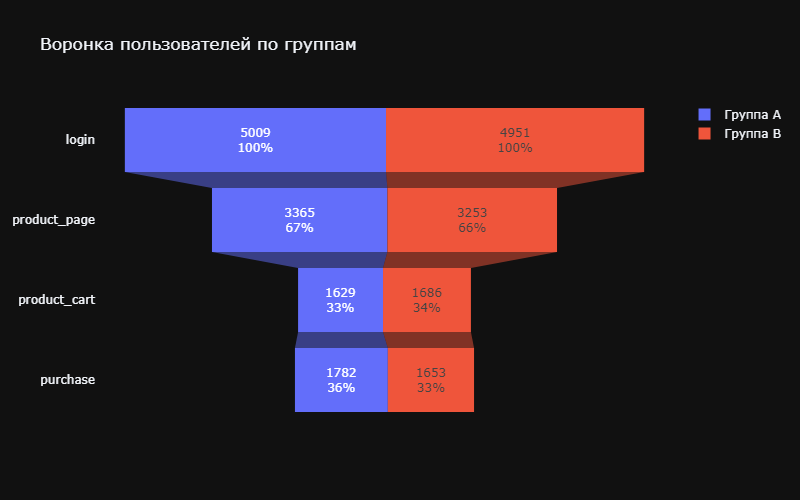

In [48]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = total_funnel.query('group == "A"')['event_name'],
    x = total_funnel.query('group == "A"')['users_count'],
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y = total_funnel.query('group == "B"')['event_name'],
    x = total_funnel.query('group == "B"')['users_count'],
    textinfo = "value+percent initial"))

fig.update_layout(
    title="Воронка пользователей по группам",
    template='plotly_dark',
    width=800, 
    height=500,
)

fig.show()

- Треть пользователей отваливаются при переходе к просмотру карточки товара
- Только половина от посмотревших карточку товара, переходит в корзину
- Интереснее последний переход: в группе А количество оплативших товар пользователей больше, чем количество пользователей, посмотревших корзину
- Судя по всему - оплатить товар можно, не заходя в корзину
- В целом, между предпоследним и последним этапом конверсия практически стопроцентная
- Предварительно - по этому графику, мы не видим улучшений по конверсии

**Распределение количества событий на пользователя в разных группах**

In [49]:
events_per_user = total_df.groupby('user_id', as_index=False) \
    .agg({'event_name':'count', 'group':'max'})\
    .rename(columns={'event_name':'events_count'})

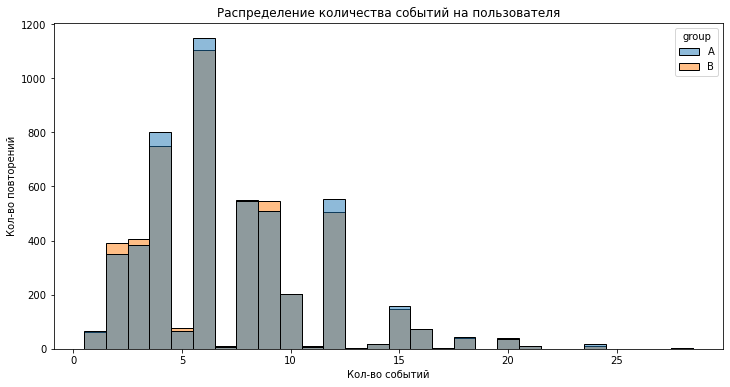

In [50]:
plt.figure(figsize=(12,6))
sns.histplot(events_per_user, x='events_count', hue='group', discrete=True)
plt.title("Распределение количества событий на пользователя")
plt.xlabel('Кол-во событий')
plt.ylabel('Кол-во повторений')
pass

Видим, что количества событий на пользователя в двух группах распредлены примерно одинаково. Где-то чуть выше группа B, где-то А, но в целом, характерных отличий нет. Выбросов нет, распределение расположено вполне компактно. Посмотрим еще дополнительные показатели.

In [51]:
print('Всего событий в логе:', total_df['event_name'].count())
print('Событий на одного пользователя в среднем: {:.1f}'.format(events_per_user['events_count'].mean()))

Всего событий в логе: 71561
Событий на одного пользователя в среднем: 7.2


In [52]:
print('Событий на одного пользователя в среднем (гр.А): {:.1f}'.format(events_per_user.query('group == "A"')['events_count'].mean()))
print('Событий на одного пользователя в среднем (гр.B): {:.1f}'.format(events_per_user.query('group == "B"')['events_count'].mean()))

Событий на одного пользователя в среднем (гр.А): 7.2
Событий на одного пользователя в среднем (гр.B): 7.1


Средние значения практически идентичны

**В выборках встречаются одни и те же пользователи?**

Мы уже проверяли это ранее - на этапе предобработки, но на всякий случай посмотрим еще раз. 

In [53]:
print('Дублирующихся пользователей в группах:', events_per_user.duplicated(subset='user_id').sum())

Дублирующихся пользователей в группах: 0


**Распределение числа событий по дням**

In [54]:
total_df['event_date'] = total_df['event_dt'].dt.date

In [55]:
events_per_date = total_df.groupby(['event_date', 'group'], as_index=False) \
    .agg({'event_name':'count'}) \
    .rename(columns={'event_name':'events_count'})

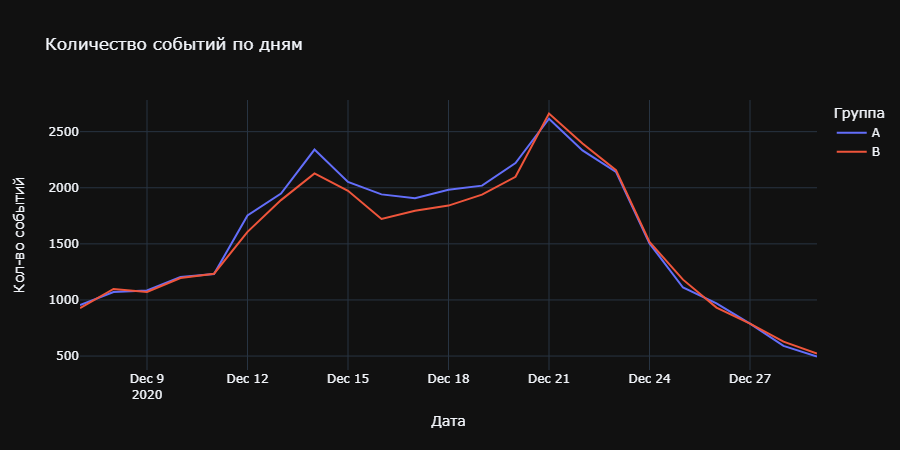

In [56]:
px.line(events_per_date, 
        x='event_date', 
        y='events_count', 
        color='group',
        title="Количество событий по дням",
        template='plotly_dark',
        labels={'event_date':'Дата', 'events_count':'Кол-во событий', 'group':'Группа'},
        width=900, 
        height=450)

- Видим, что форма графиков двух группа примерно одинаковая.
- Есть два пика (14 и 21 декабря) - это ровно неделя и две недели с начала теста. Предполагаю, что в эти дни больше всего именно событий login, то есть пользователей набирали. 
- Между двумя пиками группа А по событиям превосходит группа B
- Не смотря на то, что тест длился до 4 января, события в нашем датасэте заканчиваются 30 декабря. 
- 25 января в нашем регионе проходила маркетинговая акция "Рождественское промо": её влияния (что хорошо) на графике не видно

**Дополнительно: посмотрим на среднюю сумму покупки по группам**

In [57]:
purchases = total_df.query('event_name == "purchase"')

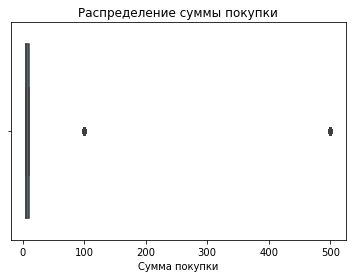

In [58]:
sns.boxplot(data=purchases, x='details')
plt.xlabel('Сумма покупки')
plt.title("Распределение суммы покупки")
pass

Есть два выброса, уберем их и посмотрим гистограмму распределения. 

In [59]:
purchases = purchases.query('details < 90')

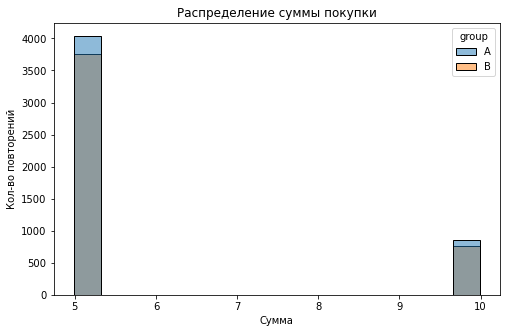

In [60]:
plt.figure(figsize=(8,5))
sns.histplot(purchases, x='details', hue='group')
plt.title("Распределение суммы покупки")
plt.xlabel('Сумма')
plt.ylabel('Кол-во повторений')
pass

Видим, что суммы всего 2 (если вспомнить выбросы, то 4). Судя по всему, там 4.99 и 9.99. Вряд ли это подписки, потому что у нас есть карточки товаров и корзины. Значит, просто стоимость у товаров такая фиксированная. 

В итоге, средние можем даже не смотреть. Уже по гистограмме видим, что пользователи группы А тратят больше.

## 5. Оценка результатов A/B-теста

Проделаем несколько вспомогательных операций и напишем несколько функций, чтобы результаты вывелись в одной итоговой табличке

In [61]:
#приведем в порядок индексы
total_funnel.reset_index(drop=True, inplace=True)

In [62]:
#вспомогательная функция, которая возвращает количество пользователей на указанном этапе воронки в выбранной группе
def users_count(group, step):
    users_count = 0
    users_count = total_funnel.query('group == @group & event_name == @step')['users_count'].sum()
    return users_count

In [63]:
#функция, которая считает две конверсии в разных группах и результат z-теста
#итог возвращается в виде строчки, которая затем передается в финальную функцию
def conversion_comparison(prev_step, next_step):
    prev_step_users = [users_count("A", prev_step), users_count("B", prev_step)]
    next_step_users = [users_count("A", next_step), users_count("B", next_step)]
    
    conversionA = (next_step_users[0] / prev_step_users[0]).round(2)
    conversionB = (next_step_users[1] / prev_step_users[1]).round(2)
    p_value = proportions_ztest(next_step_users, prev_step_users, alternative='two-sided')[1].round(5)
    test_name = 'Конверсия из ' + prev_step + ' в ' + next_step
    results = [test_name, conversionA, conversionB, p_value]
    
    return results

In [64]:
#итоговая функция, которая выводит табличку с результатами сравнения между двумя группами по всем этапам конверсии
def group_comparison():
    results = []
    
    for event in total_funnel['event_name'].unique():
        results.append(conversion_comparison('login', event))
        
    columns_names = ['Этап', 'Конверсия А', 'Конверсия B', 'p-value']

    return pd.DataFrame(data=results, columns=columns_names)

**Результаты стат.теста**
- H0: Конверсия (между определенными этапами воронки) в двух группах одинаковая
- H1: Конверсия (между определенными этапами воронки) в двух группах различается
- Оцениваем результаты на уровне значимости 0.05
- Поскольку мы будем проверять не одну, а сразу 4 гипотезы (3 сейчас и одну дополнительную) на одних и тех же данных, то стоит скорректировать уровень значимости. Воспользуемся методом Бонферрони. 
- Итого: для каждого отдельного теста используем alpha = 0.05 / 4 = 0.0125

In [65]:
group_comparison().drop(0)

,Этап,Конверсия А,Конверсия B,p-value
1,Конверсия из login в product_page,0.67,0.66,0.11901
2,Конверсия из login в product_cart,0.33,0.34,0.10469
3,Конверсия из login в purchase,0.36,0.33,0.02158


**Вывод по результатам**

Ни один из тестов не показал значимых изменений. Вкупе со значениями конверсий напрашивается вывод о том, что изменения как минимум не влияют на конверсию, а как максимум - ухудшают её. 

**Дополнительный тест**

Мы помним, что пользователи, судя по всему, могут оплачивать товар, не переходя в корзину. Что если у нас улучшилась конверсия из product_page в purchase? Проверим это. 

In [66]:
conversion_comparison('product_page', 'purchase')

['Конверсия из product_page в purchase', 0.53, 0.51, 0.0812]

Нет, z-тест говорит, что разница не значима. А та что есть все равно показывает, что результаты лучше в контрольной группе. 

## Выводы

**В данном проекте мы** анализировали данные по A/B-тестам:

- Проверили корректность проведения;
- Проанализировали результаты;

**Корректность проведения теста "recommender_system_test", указанного в ТЗ, вызывает вопросы:**
- Пользователей мало
- Есть пересечение с маркетинговой активностью
- Присутствуют пользователи из других регионов
- Пользователи неравномерно распределены между группами
- Есть пересечения с пользователями из другого теста

Анализировать результаты этого теста было бесполезно (много искажений), поэтому мы взглянули на второй тест - 'interface_eu_test' и проанализровали его результаты. 

**Результаты анализа А/B-теста "interface_eu_test":**

Общие выводы о данных: 
- 30% пользователей отваливаются при переходе к просмотру карточки товара
- Только половина от посмотревших карточку товара, переходит в корзину
- Судя по всему - оплатить товар можно, не заходя в корзину
- Между предпоследним и последним этапом конверсия практически стопроцентная
- В группе А немного выше средний чек (но, статистическую значимость этих различий мы не проверяли)

Анализ конверсий (z-тест на уровне значимости 0.05 для каждого отдельного теста):
- Мы не увидели значимых изменений конверсии. А если принимать в расчет сами значения конверсии, то можно сказать, что мы либо не видим изменений, либо вообще скорее получили ухудшение. 

**Итоговый вывод:**

Ожидаемого эффекта не достигли. Тест "interface_eu_test" - неудачный и эти изменения внедрять не стоит. 